# Monitoring setup for Bicycle Sharing Demand Prediction

This notebook shows how you can use the Evidently to:
* calculate performance and data drift for the model, performed as batch checks 
* log models quality & data drift using MLflow Tracking
* explore the result 

More examples are available in the github: https://github.com/evidentlyai/evidently/tree/main/examples

Evidently docs: https://docs.evidentlyai.com/

Join our Discord: https://discord.com/invite/xZjKRaNp8b

In [1]:
try:
    import evidently
except:
    !pip install git+https://github.com/evidentlyai/evidently.git

In [2]:
import datetime
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, ensemble, model_selection
from scipy.stats import anderson_ksamp

from evidently.metrics import RegressionQualityMetric, RegressionErrorPlot, RegressionErrorDistribution
from evidently.metric_preset import DataDriftPreset, RegressionPreset
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.report import Report

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Bicycle Demand Data

More information about the dataset can be found in UCI machine learning repository: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Acknowledgement: Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg

In [4]:
content = requests.get("https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip", verify=False).content
with zipfile.ZipFile(io.BytesIO(content)) as arc:
    df = pd.read_csv(arc.open("hour.csv"), header=0, sep=',', parse_dates=['dteday']) 

In [5]:
df.index = df.apply(lambda row: datetime.datetime.combine(row.dteday.date(), datetime.time(row.hr)),
                                axis=1)

In [6]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [7]:
print (df.index.min())
print (df.index.max())

2011-01-01 00:00:00
2012-12-31 23:00:00


In [8]:
df['weekday'].value_counts()

weekday
6    2512
0    2502
5    2487
1    2479
3    2475
4    2471
2    2453
Name: count, dtype: int64

### **Attributes Information**
 
### Deskripsi Kolom

| Nama Kolom | Deskripsi | Tipe Data |
|---|---|---|
| `instant` | ID unik untuk setiap baris data | `int64` |
| `date` | Tanggal | `datetime64[ns]` |
| `season` | Musim (1: Spring, 2: Summer, 3: Fall, 4: Winter) | `int64` |
| `weather` | Cuaca (1: Clear, 2: Cloudy, 3: Rainy, 4: Snowy) | `int64` |
| `temp` | Temperatur (Celsius) | `float64` |
| `atemp` | Temperatur yang terasa (Celsius) | `float64` |
| `humidity` | Kelembapan (%) | `float64` |
| `windspeed` | Kecepatan angin (km/jam) | `float64` |
| `casual` | Jumlah pengguna kasual | `int64` |
| `registered` | Jumlah pengguna terdaftar | `int64` |
| `count` | Jumlah total penggunaan sepeda | `int64` |
| `weekday` | Hari dalam seminggu (0: Sunday, 1: Monday, ..., 6: Saturday) | `int64` |
| `workingday` | Hari kerja (0: No, 1: Yes) | `int64` |
| `holiday` | Hari libur (0: No, 1: Yes) | `int64` |
| `yr` | Tahun | `int64` |
| `mnth` | Bulan (1: January, 2: February, ..., 12: December) | `int64` |
| `hum` | Kelembapan (%) | `float64` |

### Catatan

- Kolom `instant` tidak memiliki makna intrinsik dan hanya digunakan untuk identifikasi.
- Kolom `date` direpresentasikan dalam format `datetime64[ns]`, yang menunjukkan tanggal dan waktu dengan presisi nanosecond.
- Kolom `season`, `weather`, `weekday`, `workingday`, `holiday`, `yr`, dan `mnth` bersifat kategorikal.
- Kolom `temp`, `atemp`, `humidity`, `windspeed`, `casual`, `registered`, `count`, dan `hum` bersifat numerik.

### Referensi

- [UCI Machine Learning Repository: Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)




In [9]:
df.duplicated().sum()

0

In [10]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## Model training 

In [11]:
df.drop(columns='instant', inplace=True)

In [12]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce 

In [13]:
target = 'cnt'
prediction = 'prediction'
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'mnth', 'hr', 'weekday']
categorical_features = ['season', 'holiday', 'workingday', ]#'weathersit']

In [14]:
# Transform every categorical columns into numerical
transformer = ColumnTransformer([
    ("binary", ce.BinaryEncoder(), categorical_features),
    ("onehot", OneHotEncoder(drop='first'), categorical_features)
    ,
],remainder='passthrough')

In [15]:
reference = df.loc['2011-01-01 00:00:00':'2011-01-28 23:00:00']
current = df.loc['2011-01-29 00:00:00':'2011-02-28 23:00:00']

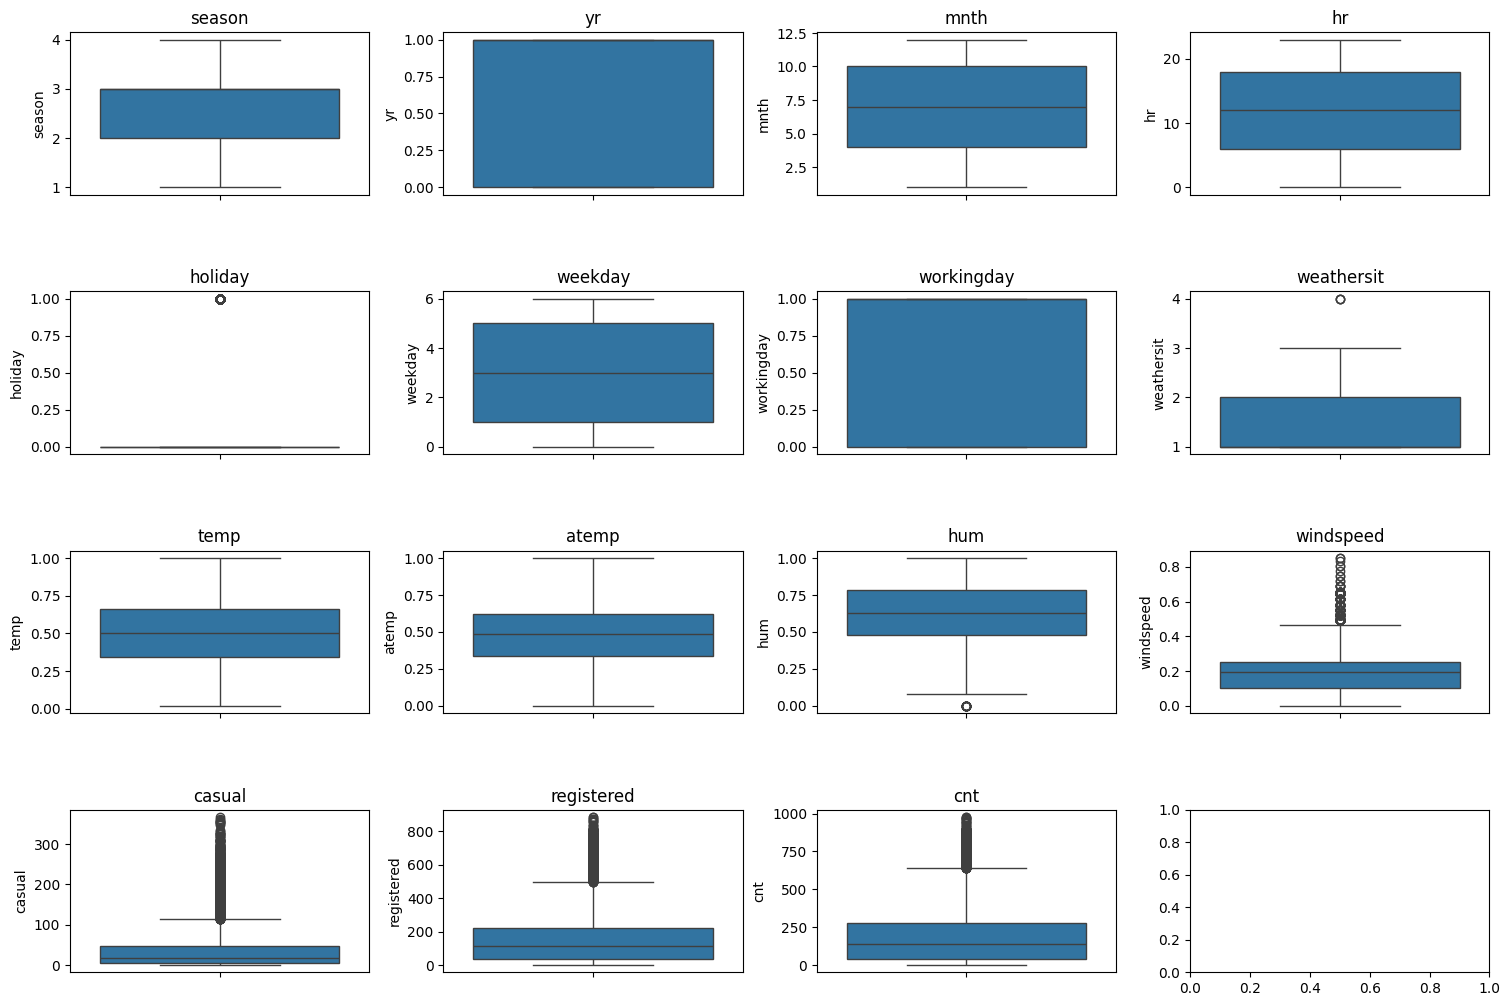

In [16]:
from math import ceil
# Dapatkan kolom numerik
df_numerik = df.drop(['dteday'], axis=1).select_dtypes(include=[float, int]).columns

# Hitung jumlah kolom dan baris yang dibutuhkan untuk grid subplot
n_cols = min(4, len(df_numerik))  # Maksimalkan 4 kolom
n_rows = int(ceil(len(df_numerik) / n_cols))

# Buat grid subplot
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, 10))
ax = ax.flatten()  # Ratakan array subplot untuk iterasi

# Buat boxplot untuk setiap kolom numerik
for i, kolom in enumerate(df_numerik):
    sns.boxplot(y=kolom, data=df, ax=ax[i])
    ax[i].set_title(kolom)  # Tambahkan judul untuk setiap subplot

# Atur tata letak subplot
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

# Tampilkan plot
plt.show()

In [17]:
def hitung_outlier_iqr(df, exclude_cols=["weathersit", "hum", "holiday"]):
    """Calculates IQR-based outlier bounds for each numeric column in a DataFrame.

    Args:
        df: The input DataFrame.
        exclude_cols: A list of columns to exclude from outlier detection.

    Returns:
        A tuple of two dictionaries:
            - lower_bound: A dictionary mapping column names to their IQR-based lower outlier bounds.
            - upper_bound: A dictionary mapping column names to their IQR-based upper outlier bounds.
    """

    lower_bound, upper_bound = {}, {}
    for col in df.select_dtypes(include=[float, int]).columns:
        if col in exclude_cols:
            continue

        q25, q75 = np.percentile(df[col], [25, 75])
        iqr = q75 - q25
        lower_bound[col] = q25 - 1.5 * iqr
        upper_bound[col] = q75 + 1.5 * iqr

    return lower_bound, upper_bound

def hapus_outlier(df, lower_bound, upper_bound, exclude_cols):
  """
  Fungsi untuk menghapus outlier pada kolom numerik dataset.

  Args:
    df: Dataframe Pandas yang berisi data.
    lower_bound: Dictionary yang berisi batas bawah outlier untuk setiap kolom.
    upper_bound: Dictionary yang berisi batas atas outlier untuk setiap kolom.
    exclude_cols: Daftar kolom yang tidak akan diproses.

  Returns:
    Dataframe Pandas dengan outlier yang telah dihapus.
  """

  for col in df.select_dtypes(include=[float, int]).columns:
    if col in exclude_cols:
      continue

    # Hapus data yang nilainya di luar batas outlier
    df = df.loc[(df[col] >= lower_bound[col]) & (df[col] <= upper_bound[col])]

  return df

def hapus_outlier_iteratif(df, exclude_cols):
    """
  Fungsi untuk menghapus outlier secara iteratif pada kolom numerik dataset.

  Args:
    df: Dataframe Pandas yang berisi data.
    exclude_cols: Daftar kolom yang tidak akan diproses.

  Returns:
    Dataframe Pandas dengan outlier yang telah dihapus.
  """

    while True:
        # Hitung batas outlier
        lower_bound, upper_bound = hitung_outlier_iqr(df, exclude_cols)

        # Hitung jumlah outlier sebelum penghapusan
        n_outlier_before = 0
        for col in df.select_dtypes(include=[float, int]).columns:
            if col in exclude_cols:
                continue
            n_outlier_before += (df[col] < lower_bound[col]).sum() + (df[col] > upper_bound[col]).sum()

        # Hapus outlier
        df = hapus_outlier(df, lower_bound, upper_bound, exclude_cols)

        # Hitung jumlah outlier setelah penghapusan
        n_outlier_after = 0
        for col in df.select_dtypes(include=[float, int]).columns:
            if col in exclude_cols:
                continue
            n_outlier_after += (df[col] < lower_bound[col]).sum() + (df[col] > upper_bound[col]).sum()

        # Keluar dari loop jika tidak ada outlier yang dihapus
        if n_outlier_before == n_outlier_after:
            break

    return df


In [18]:
# Hitung batas outlier dengan IQR
# lower_bound, upper_bound = hitung_outlier_iqr(df)

# Kolom yang tidak akan diproses
exclude_cols = ['weathersit', 'hum', 'holiday']

# Hapus outlier
df = hapus_outlier_iteratif(df, exclude_cols)

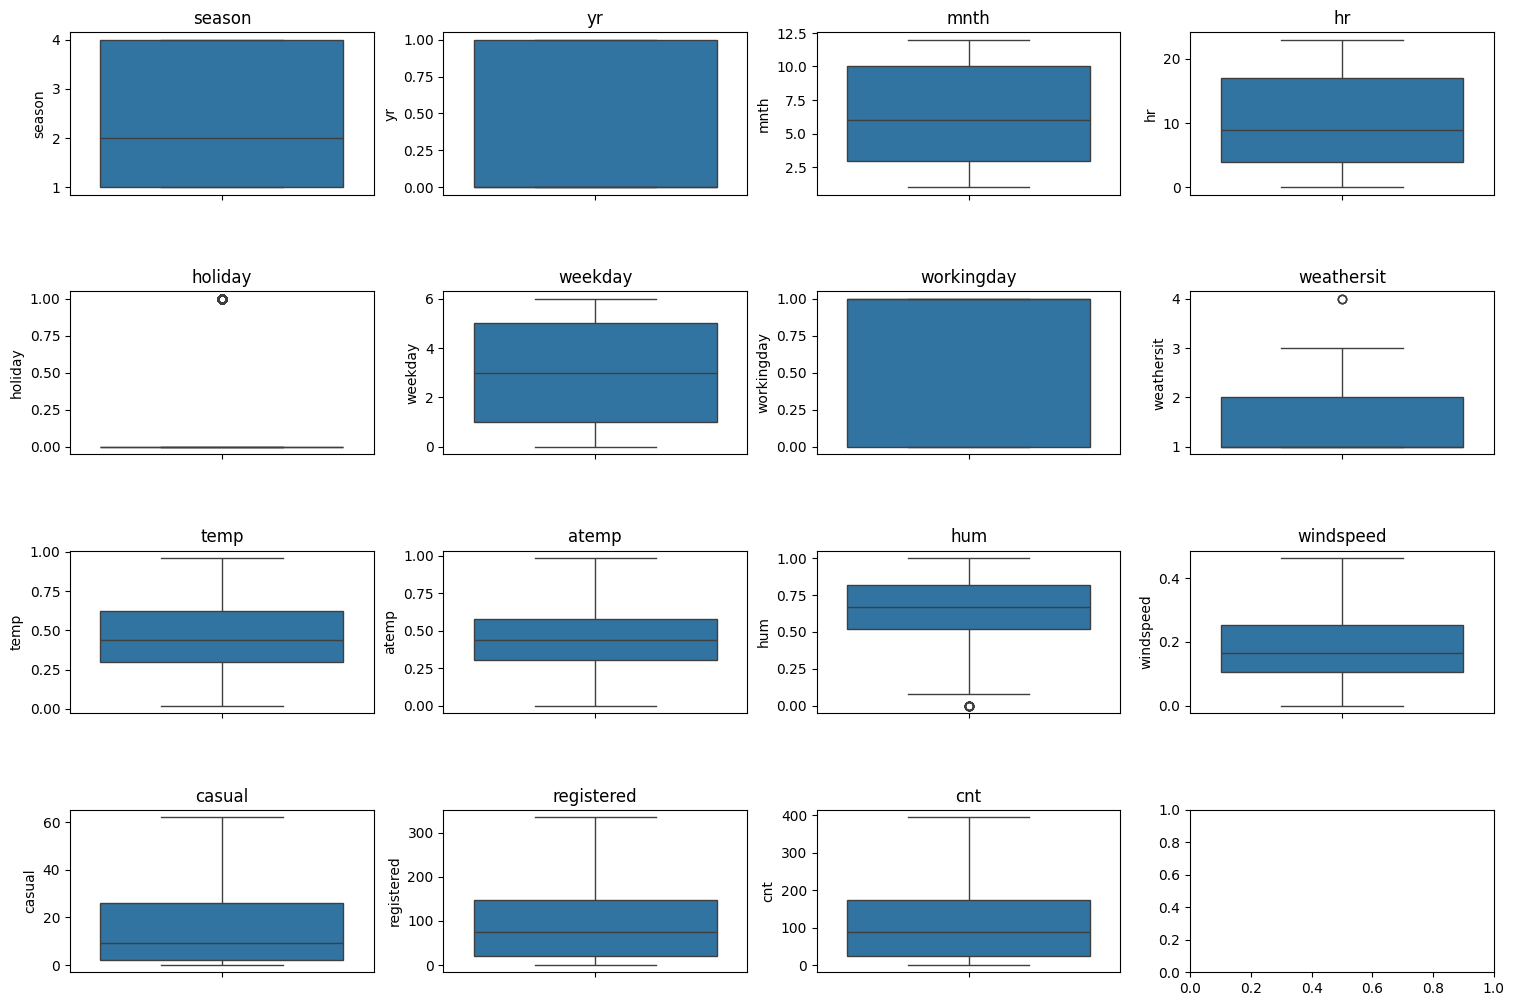

In [19]:
from math import ceil
# Dapatkan kolom numerik
df_numerik = df.drop(['dteday'], axis=1).select_dtypes(include=[float, int]).columns

# Hitung jumlah kolom dan baris yang dibutuhkan untuk grid subplot
n_cols = min(4, len(df_numerik))  # Maksimalkan 4 kolom
n_rows = int(ceil(len(df_numerik) / n_cols))

# Buat grid subplot
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, 10))
ax = ax.flatten()  # Ratakan array subplot untuk iterasi

# Buat boxplot untuk setiap kolom numerik
for i, kolom in enumerate(df_numerik):
    sns.boxplot(y=kolom, data=df, ax=ax[i])
    ax[i].set_title(kolom)  # Tambahkan judul untuk setiap subplot

# Atur tata letak subplot
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

# Tampilkan plot
plt.show()

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    reference[numerical_features + categorical_features],
    reference[target],
    test_size=0.3,
    random_state=10
)

In [21]:
regressor = ensemble.RandomForestRegressor(random_state = 0, n_estimators = 50)

In [22]:
# from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from xgboost.sklearn import XGBRegressor
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.model_selection import cross_val_score, RandomizedSearchCV
# from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, mean_absolute_error
# # from sklearn.preprocessing import FunctionTransformer

# # Membangun pipeline dengan ColumnTransformer dan model regresi
# lg = LinearRegression(n_jobs=-1)
# rd = Ridge(max_iter=1000, random_state=42)
# ls = Lasso(max_iter=1000, random_state=42)
# rf = RandomForestRegressor(bootstrap=False, random_state=42, n_jobs=-1)
# xgb = XGBRegressor(random_state=42, n_jobs=-1)
# knn = KNeighborsRegressor(n_jobs=-1, n_neighbors = 5)
# ada = AdaBoostRegressor(random_state=42, base_estimator=DecisionTreeRegressor())

# models = [lg, rd, ls, rf, xgb, knn, ada]

# # Menggunakan make_scorer untuk membuat skor sesuai metrik evaluasi yang diinginkan
# scoring_rmse = 'neg_root_mean_squared_error'
# scoring_mae = 'neg_mean_absolute_error'
# scoring_mape = 'neg_mean_absolute_percentage_error'

# # Menyiapkan data untuk dataframe
# data = []

# for model in models:  
#     estimator = Pipeline([
#         ('preprocessing', transformer),
#         ('model', model)
#     ])
    
#     # Cross-validation dengan skor sesuai metrik evaluasi yang diinginkan
#     rmse_scores = cross_val_score(
#         estimator, X_train, y_train, 
#         cv=5, scoring=scoring_rmse, 
#         error_score='raise')
#     mean_absolute_errors = cross_val_score(
#         estimator, 
#         X_train, y_train, 
#         cv=5, 
#         scoring=scoring_mae, 
#         error_score='raise')
#     mape_scores = cross_val_score(
#         estimator, X_train, y_train, cv=5, 
#         scoring=scoring_mape, 
#         error_score='raise')
    
#     # Menyimpan informasi model, standar deviasi, dan rata-rata
#     model_name = model.__class__.__name__
#     data.append([model_name, rmse_scores.std(), rmse_scores.mean(),
#                  mean_absolute_errors.std(), mean_absolute_errors.mean(),
#                  mape_scores.std(), mape_scores.mean()])

# # Membuat dataframe
# columns = ['Model', 'RMSE Std Dev', 'RMSE Mean', 'MAE Std Dev', 'MAE Mean', 'MAPE Std Dev', 'MAPE Mean']
# results_df = pd.DataFrame(data, columns=columns)

In [23]:
# results_df

In [24]:

estimator = Pipeline([
('preprocessing', transformer),
('model', regressor)
])

In [25]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['season', 'holiday',
                                                   'workingday']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'holiday',
                                                   'workingday'])])),
                ('model',
                 RandomForestRegressor(n_estimators=50, random_state=0))])

In [26]:
preds_train = estimator.predict(X_train)
preds_test = estimator.predict(X_test)

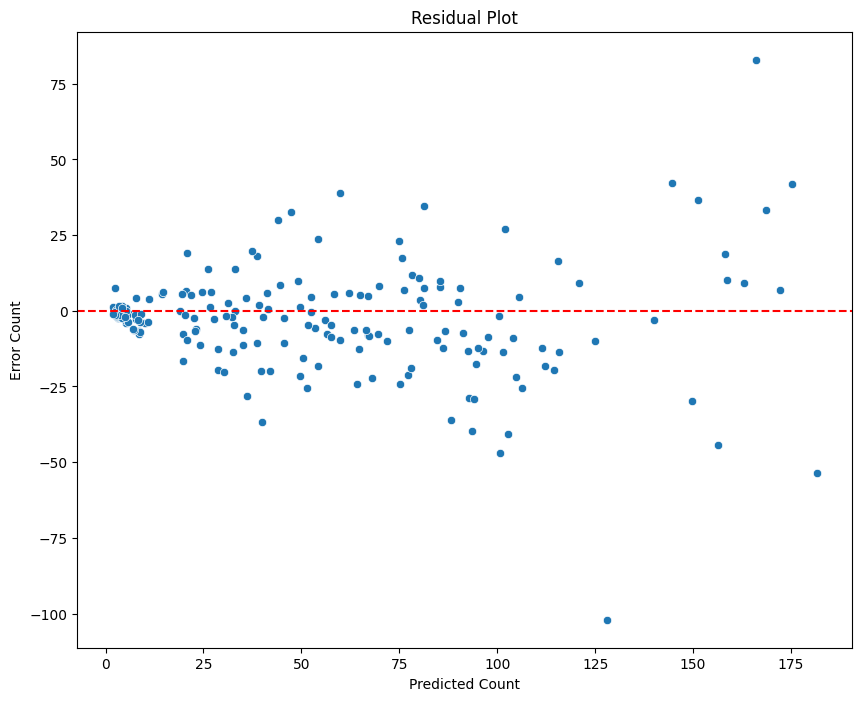

In [ ]:
residual = y_test - preds_test

plt.figure(figsize=(10,8))
sns.scatterplot(x=preds_test, y=residual).set(title='Residual Plot', xlabel='Predicted Count', ylabel='Error Count')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

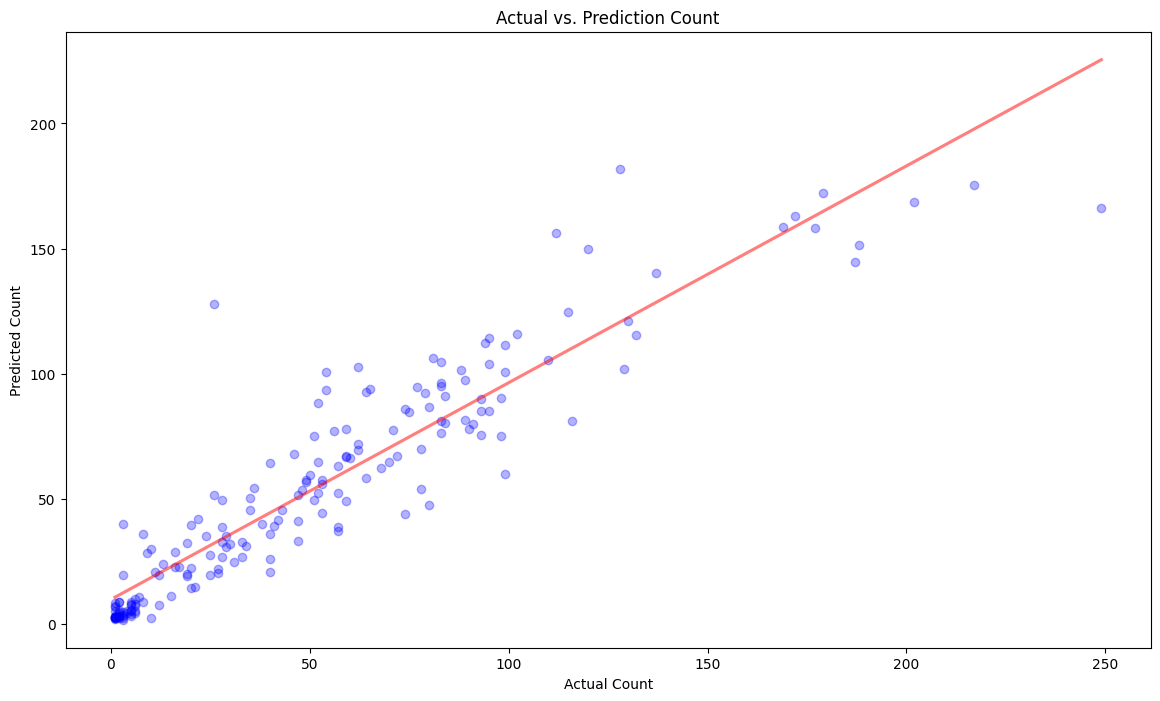

In [ ]:
plt.figure(figsize=(14, 8))
sns.regplot(x=y_test, y=preds_test, ci=None, scatter_kws = {'color': 'blue', 'alpha': 0.3}, line_kws = {'color': 'red', 'alpha': 0.5}).set(title='Actual vs. Prediction Count', 
                                               xlabel='Actual Count', 
                                               ylabel='Predicted Count')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, mean_absolute_error
score_rmse = []
score_mae = []
score_mape = []
score_rmse.append(np.sqrt(mean_squared_error(y_test, preds_test)))
score_mae.append(mean_absolute_error(y_test, preds_test))
score_mape.append(mean_absolute_percentage_error(y_test, preds_test))
score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=['before tuning'])
score_before_tuning

,RMSE,MAE,MAPE
before tuning,18.318239,11.892473,0.66461


In [ ]:
score_rmse = []
score_mae = []
score_mape = []
score_rmse.append(np.sqrt(mean_squared_error(y_train, preds_train)))
score_mae.append(mean_absolute_error(y_train, preds_train))
score_mape.append(mean_absolute_percentage_error(y_train, preds_train))
score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=['before tuning'])
score_before_tuning

,RMSE,MAE,MAPE
before tuning,6.526454,4.30375,0.188161


## Model validation

In [ ]:
X_train['target'] = y_train
X_train['prediction'] = preds_train

X_test['target'] = y_test
X_test['prediction'] = preds_test

In [ ]:
column_mapping = ColumnMapping()

column_mapping.target = 'target'
column_mapping.prediction = 'prediction'
column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features

In [ ]:
regression_performance_report = Report(metrics=[
    RegressionPreset(),
])

regression_performance_report.run(reference_data=X_train.sort_index(), current_data=X_test.sort_index(),
                                  column_mapping=column_mapping)
regression_performance_report.save_html('report.html')

## Production model training

In [ ]:
estimator.fit(reference[numerical_features + categorical_features], reference[target])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['season', 'holiday',
                                                   'workingday']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'holiday',
                                                   'workingday'])])),
                ('model',
                 RandomForestRegressor(n_estimators=50, random_state=0))])

In [ ]:
column_mapping = ColumnMapping()

column_mapping.target = target
column_mapping.prediction = prediction
column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features

In [ ]:
ref_prediction = estimator.predict(reference[numerical_features + categorical_features])
reference['prediction'] = ref_prediction

In [ ]:
regression_performance_report = Report(metrics=[
    RegressionPreset(),
])

regression_performance_report.run(reference_data=None, current_data=reference,
                                  column_mapping=column_mapping)
regression_performance_report

## Some time has passed - how is the model working?

In [ ]:
current_prediction = regressor.predict(current[numerical_features + categorical_features])
current['prediction'] = current_prediction

ValueError: X has 10 features, but RandomForestRegressor is expecting 12 features as input.

### Week 1

In [ ]:
regression_performance_report.run(reference_data=reference, current_data=current.loc['2011-01-29 00:00:00':'2011-02-07 23:00:00'],
                                  column_mapping=column_mapping)
regression_performance_report.save_html("week1.html")

### Week 2

In [ ]:
regression_performance_report = Report(metrics=[
    RegressionQualityMetric(),
    RegressionErrorPlot(),
    RegressionErrorDistribution()
])

regression_performance_report.run(reference_data=reference, current_data=current.loc['2011-02-07 00:00:00':'2011-02-14 23:00:00'], 
                                            column_mapping=column_mapping)
regression_performance_report.show()

### Week 3

In [ ]:
regression_performance_report = Report(metrics=[
    RegressionQualityMetric(),
    RegressionErrorPlot(),
    RegressionErrorDistribution()
])

regression_performance_report.run(reference_data=reference, current_data=current.loc['2011-02-15 00:00:00':'2011-02-21 23:00:00'], 
                                            column_mapping=column_mapping)
regression_performance_report.show()

## Why the quality has dropped?

In [ ]:
column_mapping_drift = ColumnMapping()

column_mapping_drift.target = target
column_mapping_drift.prediction = prediction
column_mapping_drift.numerical_features = numerical_features
column_mapping_drift.categorical_features = []

In [ ]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(
    reference_data=reference,
    current_data=current.loc['2011-02-14 00:00:00':'2011-02-21 23:00:00'],
    column_mapping=column_mapping_drift,
)
data_drift_report

## Let's customize the report!

In [ ]:
from evidently.core import ColumnType
from evidently.calculations.stattests import StatTest, register_stattest
from scipy.stats import anderson

def _anderson_stat_test(reference_data: pd.Series, current_data: pd.Series, feature_type: ColumnType, threshold: float):
    p_value = anderson_ksamp([reference_data, current_data])[2]
    return p_value, p_value < threshold

anderson_stat_test = StatTest(
    name="anderson",
    display_name="Anderson test (p_value)",
    allowed_feature_types=[ColumnType.Numerical],
    func=anderson  # Masukkan fungsi Anderson test
)
register_stattest(anderson_stat_test)
# options = DataDriftOptions(feature_stattest_func=anderson_stat_test, all_features_threshold=0.9, nbinsx=20)

In [ ]:
the_report = Report(metrics=[
    RegressionQualityMetric(),
    RegressionErrorPlot(),
    RegressionErrorDistribution(),
    DataDriftPreset(
    stattest=lambda data: anderson(data)[0],  # Pass only necessary data
    stattest_threshold=0.9
),
])


the_report.run(
    reference_data=reference,
    current_data=current.loc['2011-02-14 00:00:00':'2011-02-21 23:00:00'], 
    column_mapping=column_mapping_drift
)
the_report

TypeError: <lambda>() takes 1 positional argument but 4 were given

## Jupyter vs Automated Run?

To run this part of the tutorial you need to install MLflow (if not installed yet)

You can install MLflow with the following command: `pip install mlflow` or install MLflow with scikit-learn via `pip install mlflow[extras]`

More details:https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html#id5

In [ ]:
try:
    import mlflow
except:
    !pip install mlflow

zsh:1: command not found: pip


In [ ]:
import mlflow
#import mlflow.sklearn
from mlflow.tracking import MlflowClient

ModuleNotFoundError: No module named 'mlflow'

In [ ]:
experiment_batches = [
    ('2011-01-29 00:00:00','2011-02-07 23:00:00'),
    ('2011-02-07 00:00:00','2011-02-14 23:00:00'),
    ('2011-02-15 00:00:00','2011-02-21 23:00:00'),  
]

In [ ]:
the_report = Report(metrics=[
    RegressionQualityMetric(),
    RegressionErrorPlot(),
    RegressionErrorDistribution(),
    DataDriftPreset(stattest=anderson_stat_test, stattest_threshold=0.9),
])

the_report.run(
    reference_data=reference, 
    current_data=current.loc[experiment_batches[0][0]:experiment_batches[0][1]],
    column_mapping=column_mapping_drift
)

In [ ]:
logged_json = json.loads(the_report.json())

In [ ]:
logged_json

In [ ]:
[x['metric'] for x in logged_json['metrics']]

In [ ]:
logged_json['metrics'][0]['result']['current']['mean_error']

In [ ]:
logged_json['metrics'][3]['result']['drift_share']

In [ ]:
#log into MLflow
client = MlflowClient()

#set experiment
mlflow.set_experiment('Model Quality Evaluation')

#start new run
for date in experiment_batches:
    with mlflow.start_run() as run: #inside brackets run_name='test'
        
        # Log parameters
        mlflow.log_param("begin", date[0])
        mlflow.log_param("end", date[1])

        # Get metrics
        the_report = Report(metrics=[
            RegressionQualityMetric(),
            RegressionErrorPlot(),
            RegressionErrorDistribution(),
            DataDriftPreset(stattest=anderson_stat_test, stattest_threshold=0.9),
        ])
        the_report.run(
            reference_data=reference, 
            current_data=current.loc[date[0]:date[1]],
            column_mapping=column_mapping_drift)
        logged_json = json.loads(the_report.json())
        
        me = logged_json['metrics'][0]['result']['current']['mean_error']
        mae = logged_json['metrics'][0]['result']['current']["mean_abs_error"]
        drift_share = logged_json['metrics'][3]['result']['drift_share']
        
        # Log metrics
        mlflow.log_metric('me', round(me, 3))
        mlflow.log_metric('mae', round(mae, 3))
        mlflow.log_metric('drift_share', round(drift_share, 3))

        print(run.info)

In [ ]:
#run MLflow UI (NOT recommended! It will be more convinient to run it directly from the TERMINAL)
#!mlflow ui

# Support Evidently
Enjoyed the tutorial? Star Evidently on GitHub to contribute back! This helps us continue creating free open-source tools for the community. https://github.com/evidentlyai/evidently